In [93]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; # sns.set()

plt.rcParams.update({'font.size': 22})
plt.rc('font', family='serif', size=20)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

In [94]:
from IPython.core.pylabtools import figsize
figsize(35, 20)

### Constants

In [95]:
percents=[
#     (0.9999, 1.),
    (0.999, 1.),
    (0.99, 1),
    (0.8, 1),
    (.4, .6),
    (0,     .2)
]

ylabels = {
    'total_percent_change' : 'Total Percent Change',
    'percent_per_year' : 'Citation Share',
    'percent_per_year_percent_change' : 'Percent Change of Citation Share',
    'mobility' : 'Percent Mobolity',
}

### Reading

In [96]:
def read_category(category):
    with open('Results/%s.json' % category, 'r') as f:
        data = '[' + f.read()[:-1] + ']'
    
    data = eval(data)
    
    citedby = data[-1]['citedby'] if 'citedby' in data[-1].keys() else 0
    print(category, 'Authors:', len(data), citedby)
    
    df = pd.DataFrame()

    for author in data:
        try:
            years, citations = list(zip(*author['yearly_citations']))

            entry = pd.DataFrame({
                'year' : years,
                'citations' : citations,
            })
            entry['id'] = author['id']

            df = df.append(
                entry,
                ignore_index=True
            )
        except:
            pass

    for col in ['year', 'citations']:
        df[col] = pd.to_numeric(df[col])
        
    return df

### Plot Settings

In [97]:
def ax_settings(ax, title):
    if ax is None:
        fig, ax = plt.subplots()
        fig.text(0.5, 0.9, title, fontsize=20, fontweight='black', color = '#333F4B')
    else:
        ax.set_title(title, fontsize=20, fontweight='black', color = '#333F4B')
    
    ax.tick_params(axis='both', which='major', labelsize=13)
    return ax 

def label_settings(min, max):
    if max == 1:
        label = 'Top %.2g' % (100 * (1-min)) + '%'
    elif min == 0:
        label = 'Bottom %.2g' % (100 * max) + '%'
    else:
        label = 'Middle %.2g' % (100 * (max-min)) +'%'
            
    return label

def plot_settings(ax, values, grey_line_step=None, metric_type='mobility'):
    if grey_line_step is not None: 
        lines = np.arange(0, np.max(values), grey_line_step).tolist() + np.arange(-grey_line_step, np.min(values), -grey_line_step).tolist()
        for i in lines: ax.axhline(y=i, xmin=0.046, xmax=0.954, color='lightgray')
        
    ax.set_xlabel('Year', fontsize=20, fontweight='black', color = '#333F4B')
    ax.set_ylabel(ylabels[metric_type], fontsize=20, fontweight='black', color = '#333F4B'); ax.legend(prop={'size': 15}, loc='upper left', bbox_to_anchor=(0.05,0.95)) # , 

    # change the style of the axis spines
    ax.spines['top'].set_color('none'); ax.spines['right'].set_color('none'); ax.spines['left'].set_smart_bounds(True); ax.spines['bottom'].set_smart_bounds(True)
    
    ax.spines['left'].set_position(('axes', 0.02))
    ax.spines['left'].set_visible(False); ax.tick_params(axis=u'y', which=u'both',length=0); ax.tick_params(axis=u'both', which=u'both', labelsize=15)

### Computing Functions

In [98]:
def get_quantile(df_year, min, max):
                
    _, max_citation = df_year.quantile(max).values 
    _, min_citation = df_year.quantile(min).values

    quantile = df_year[ 
        (df_year['citations'] >= min_citation) &
        (df_year['citations'] <= max_citation)
    ]
    
    return quantile

def get_years(df, start_year=1985, end_year=2020):
    years = sorted(df['year'].unique())
    
    if start_year != -1:
        years = years[years.index(start_year):]
    if end_year != -1:
        years = years[:years.index(end_year)]
    
    return years

### Specific Metric Parsing Functions

In [105]:
def plot_market_share(df, percents=percents, grey_line_step=None, title='', metric_type='total_percent_change', ax=None):
    
    years = get_years(df)
        
    def get(min=0., max=1.):
        percents = []
        
        for year in years:
            
            df_year = df[df['year'] == year]
            quantile = get_quantile(df_year, min=min, max=max)                
            
            if metric_type == 'total_percent_change':
                metric = quantile['citations'].sum()
            else:
                metric = quantile['citations'].sum() / df_year['citations'].sum()
                
            percents.append(metric)
                
        return np.array(percents)
    
    def convert_to_percent(x):
        if 'percent_change' in metric_type:
            return 100. * (x - x[0]) / x[0]
        else:
            return x
    
    ax = ax_settings(ax, title)
    
    values = np.array([])
    for min,max in percents:
        metrics = get(min, max)
        earners = convert_to_percent(metrics)
            
        label = label_settings(min, max)
            
        ax.plot(years, earners, label=label) # ; plt.text(years[-1]+.1, earners[-1], str(round(earners[-1], 2)))
        ax.scatter(years[-1], earners[-1])
        
        values = np.concatenate((
            values, 
            earners
        ))
        
    plot_settings(ax, values, grey_line_step=grey_line_step)
    
        
def plot_mobility(df, title='', metric_type='mobility', ax=None):
    
    years = get_years(df)
    ax = ax_settings(ax, title)

    for min, max in percents:

        mobility = []

        for i, year in enumerate(years):

            df_year = df[df['year'] == year]
            cur_quantile = get_quantile(df_year, min=min, max=max)

            if i == 0: 
                pre_quantile = cur_quantile
                continue


            mobility.append(
                1 - pre_quantile['id'].isin(cur_quantile['id']).sum() / len(pre_quantile['id'])
            )
            pre_quantile = cur_quantile

        label = label_settings(min, max)

        ax.plot(years[1:], mobility, label=label) # ; plt.text(years[-1]+.1, earners[-1], str(round(earners[-1], 2)))
        ax.scatter(years[-1], mobility[-1])

        ax.set_ylim(0, 1)
        plot_settings(ax, mobility, grey_line_step=None)

### Generic Handler

In [100]:
def plot(plotting_func, metric_type=''):
    fig, all_ax = plt.subplots(nrows=3, ncols=5)

    for name, ax in zip(results, all_ax.flatten()):
        plotting_func(
            results[name], 
            title=name,
            metric_type=metric_type,
            ax=ax
        )

### Loading Results

In [33]:
results = {}

for file_name in os.listdir('Results/'):
    name = file_name.replace('.json','')
    results[name] = read_category(name)

artificial_intelligence Authors: 23662 19
economics Authors: 6951 21
neuroscience Authors: 18146 18
environmental_engineering Authors: 4040 0
genetics_genomics Authors: 27 27
cardiology Authors: 4871 0
civil_engineering Authors: 5013 0
biotechnology Authors: 11030 0
drug_delivery Authors: 5064 0
nanotechnology Authors: 12918 0
materials_science Authors: 9700 0
law Authors: 4703 0
hematology Authors: 2081 0
surgery Authors: 3109 0
oncology Authors: 5728 0


# Mobility

/home/jott1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in long_scalars


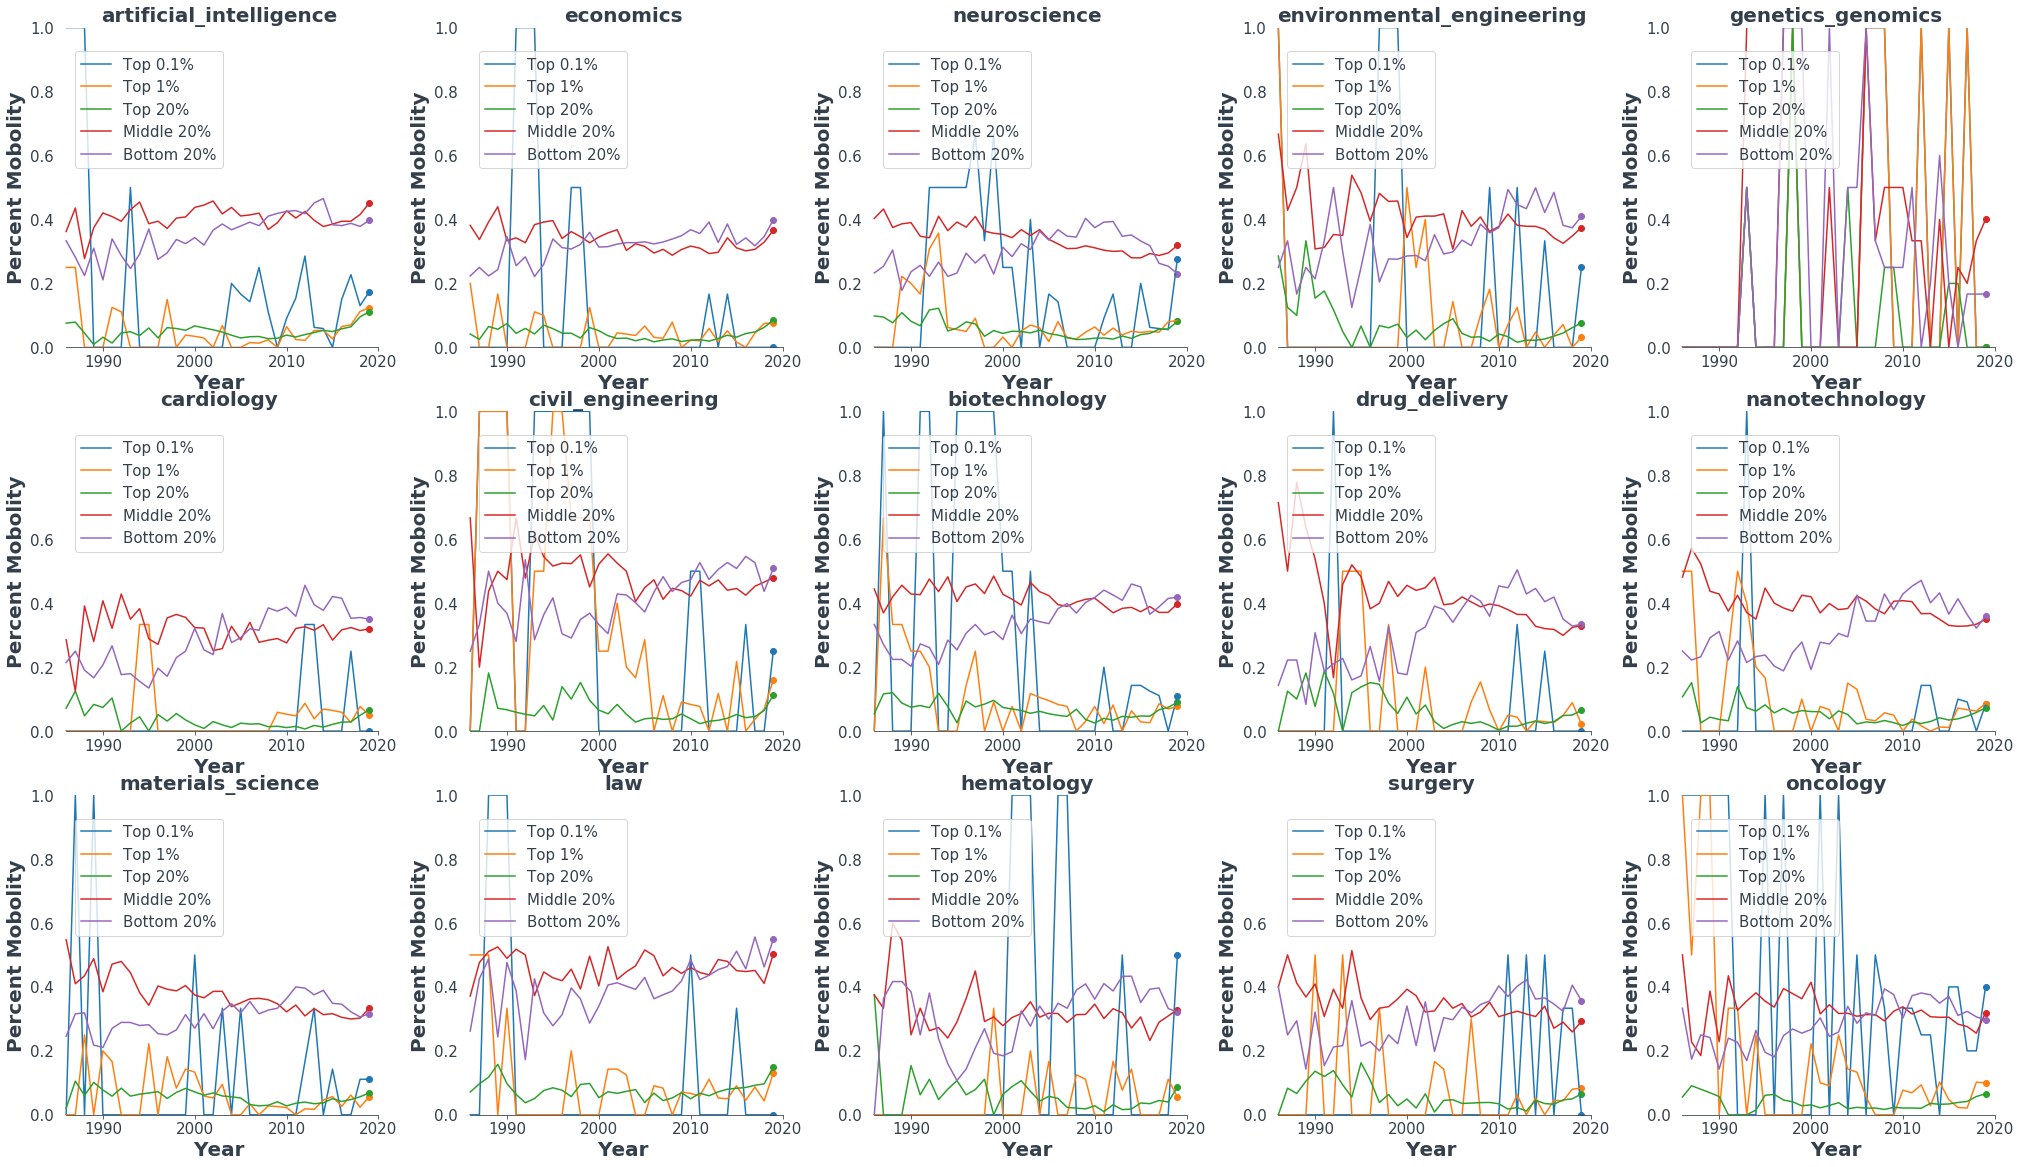

In [106]:
plot(plot_mobility, metric_type='mobility')

# Total Percent Change

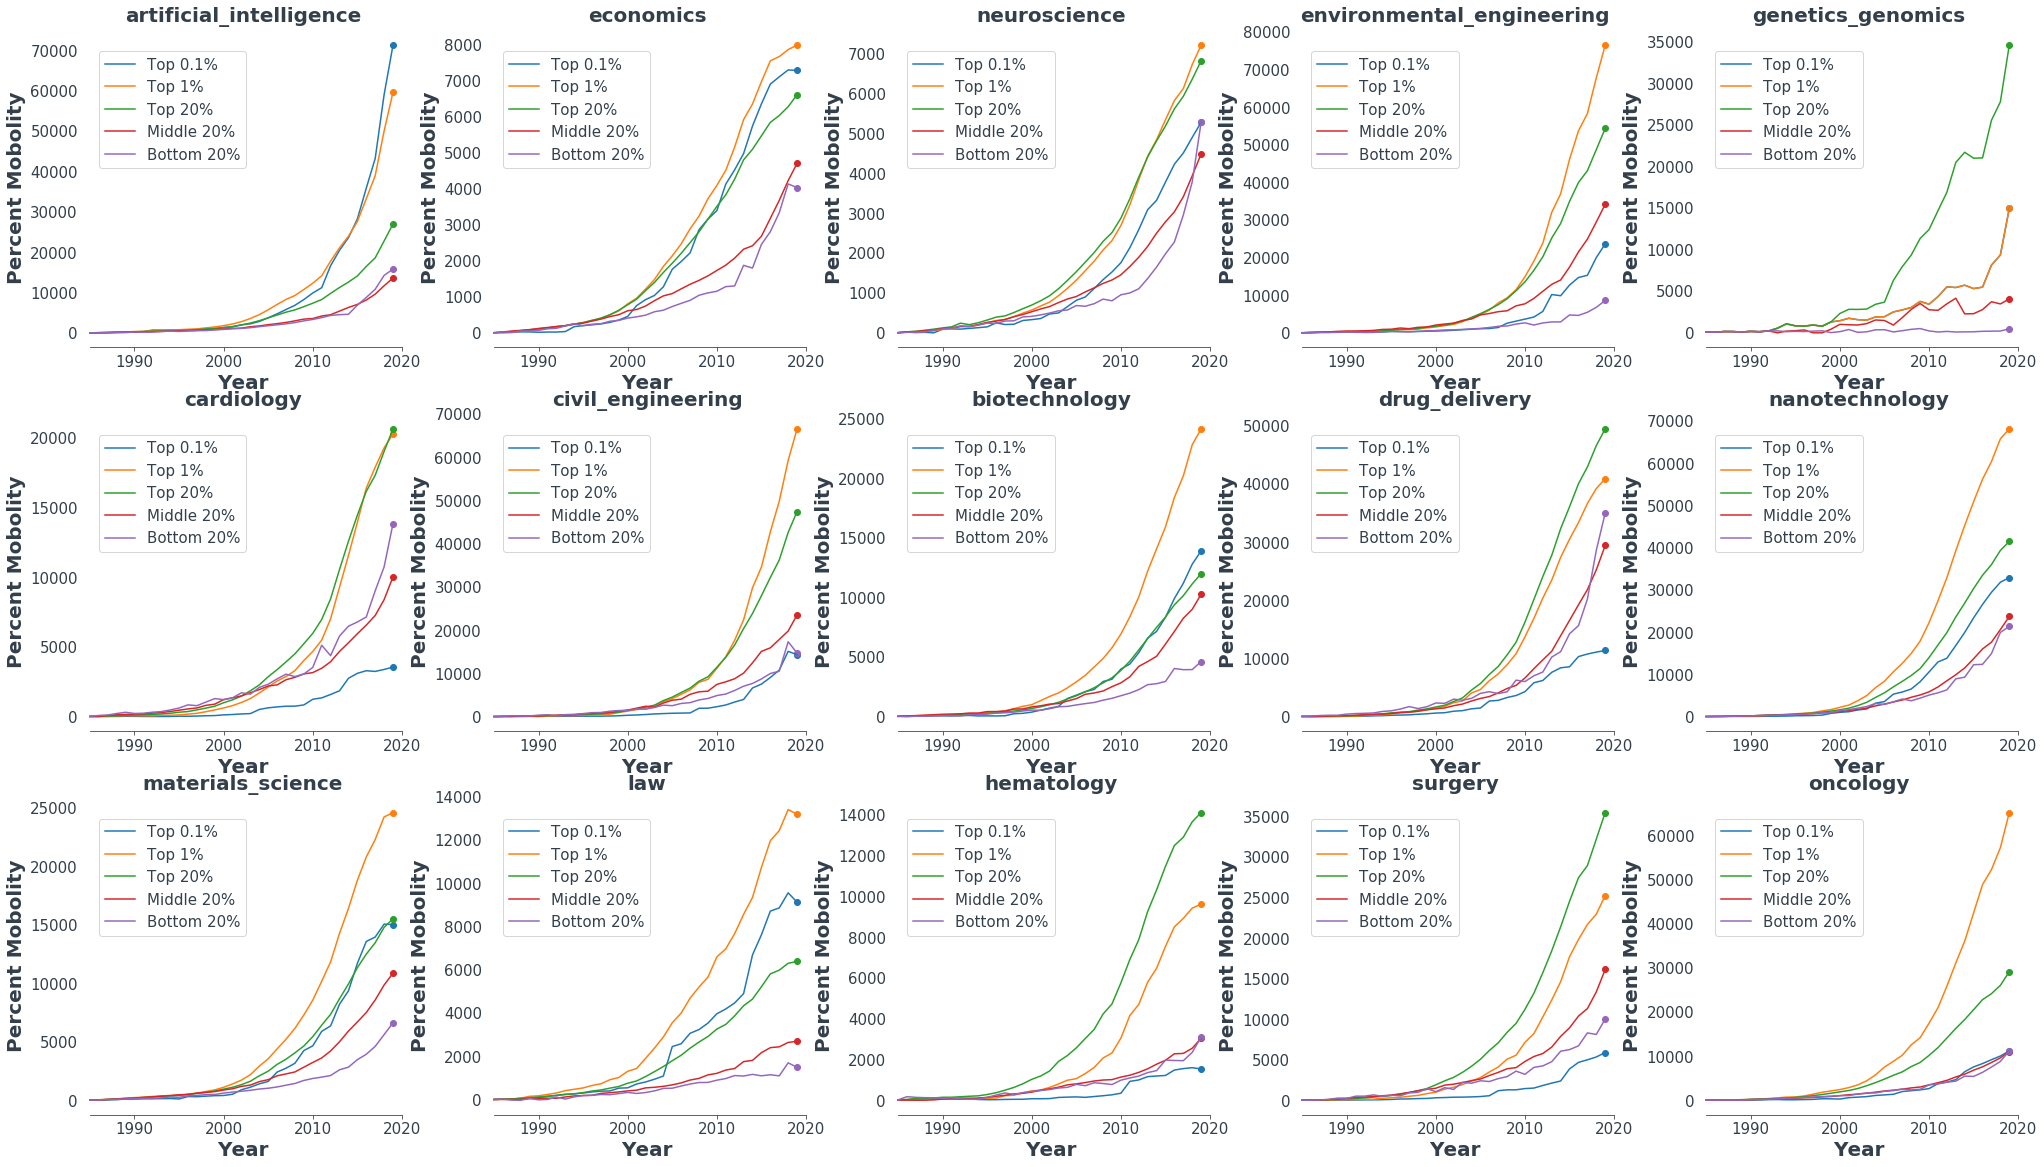

In [101]:
plot(plot_market_share, metric_type='total_percent_change')

# Percent per Year

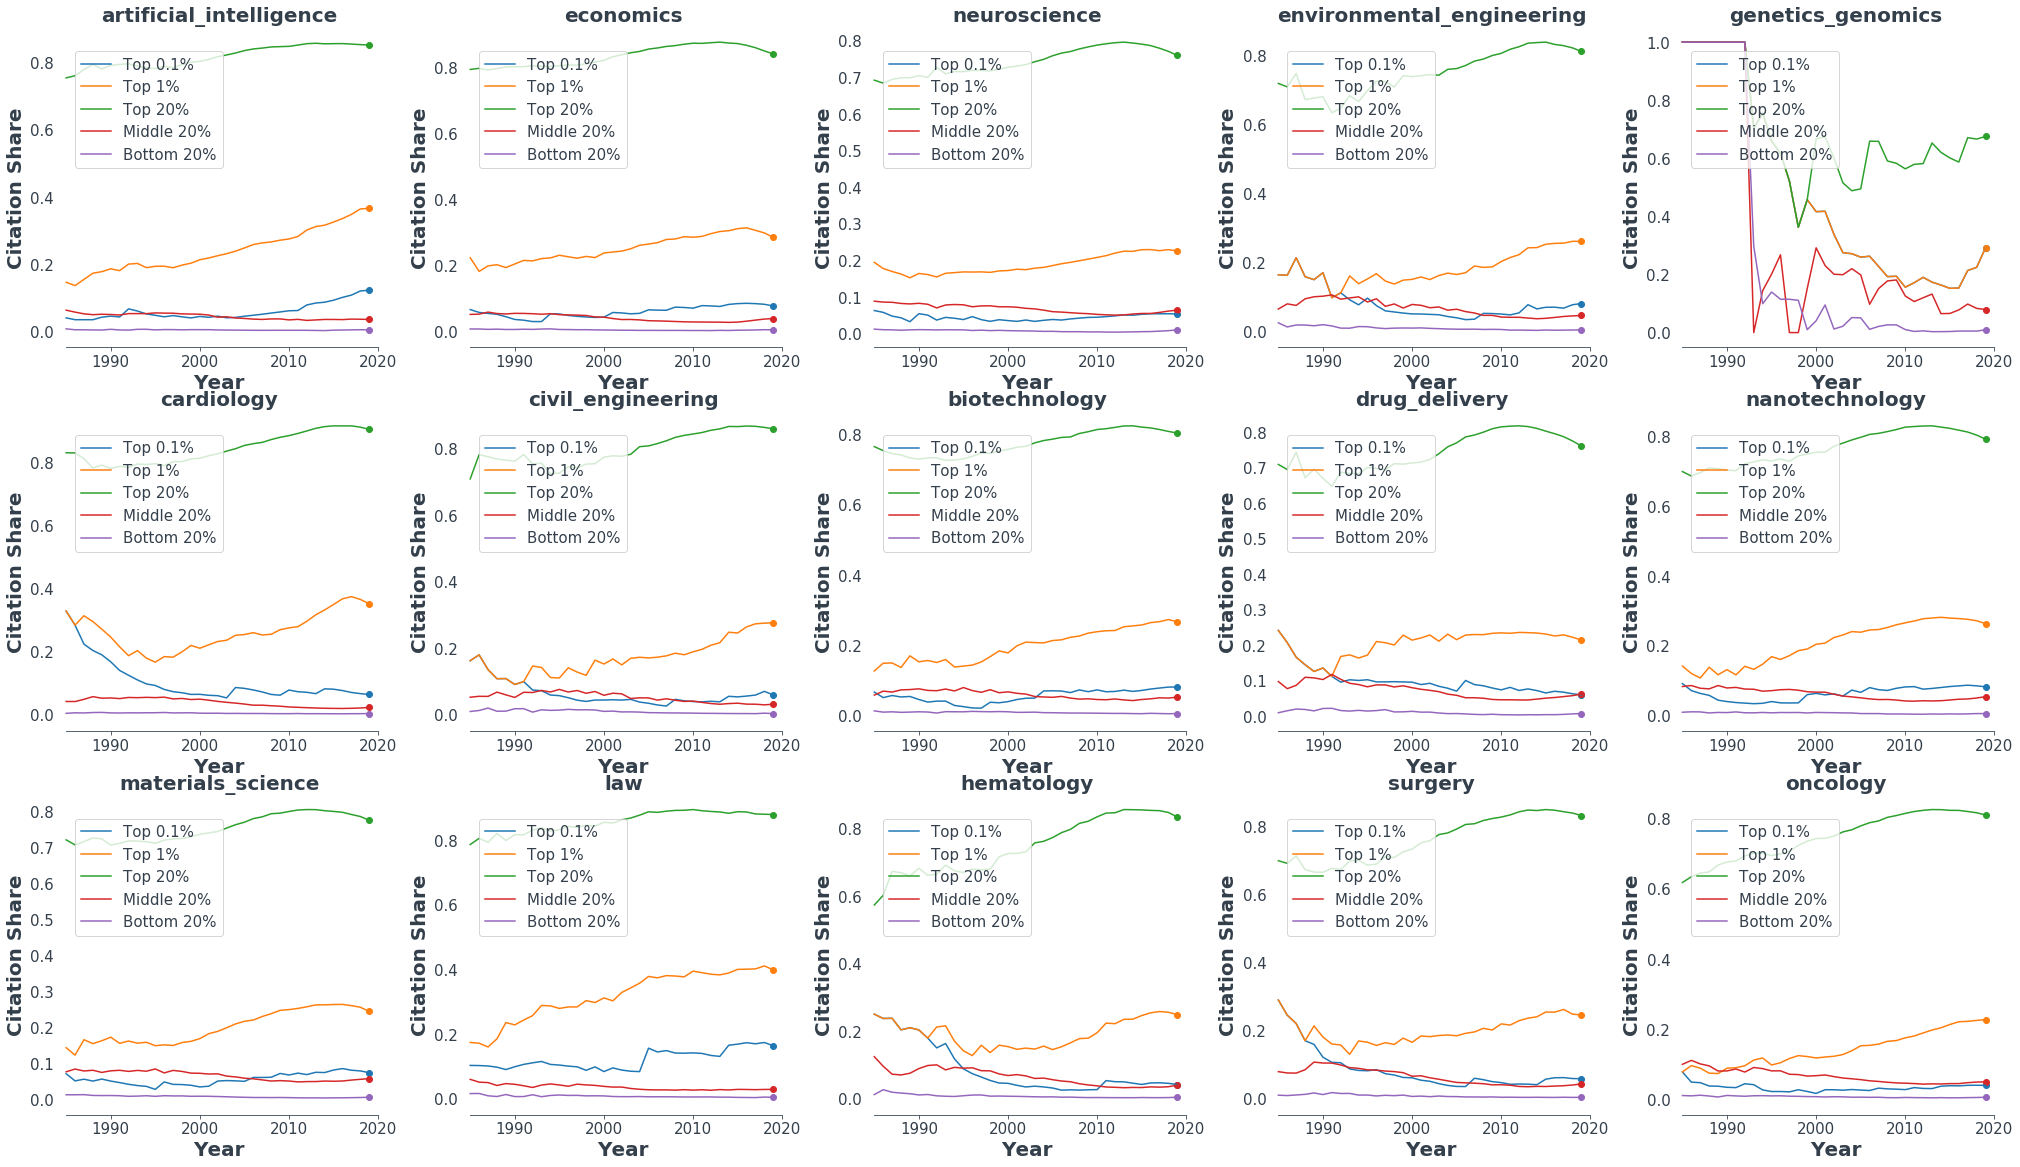

In [57]:
fig, all_ax = plt.subplots(nrows=3, ncols=5)

for name, ax in zip(results, all_ax.flatten()):
    plot(
        results[name], 
        title=name,
        metric_type='percent_per_year',
        ax=ax
    )

# Percent per Year Percent Change

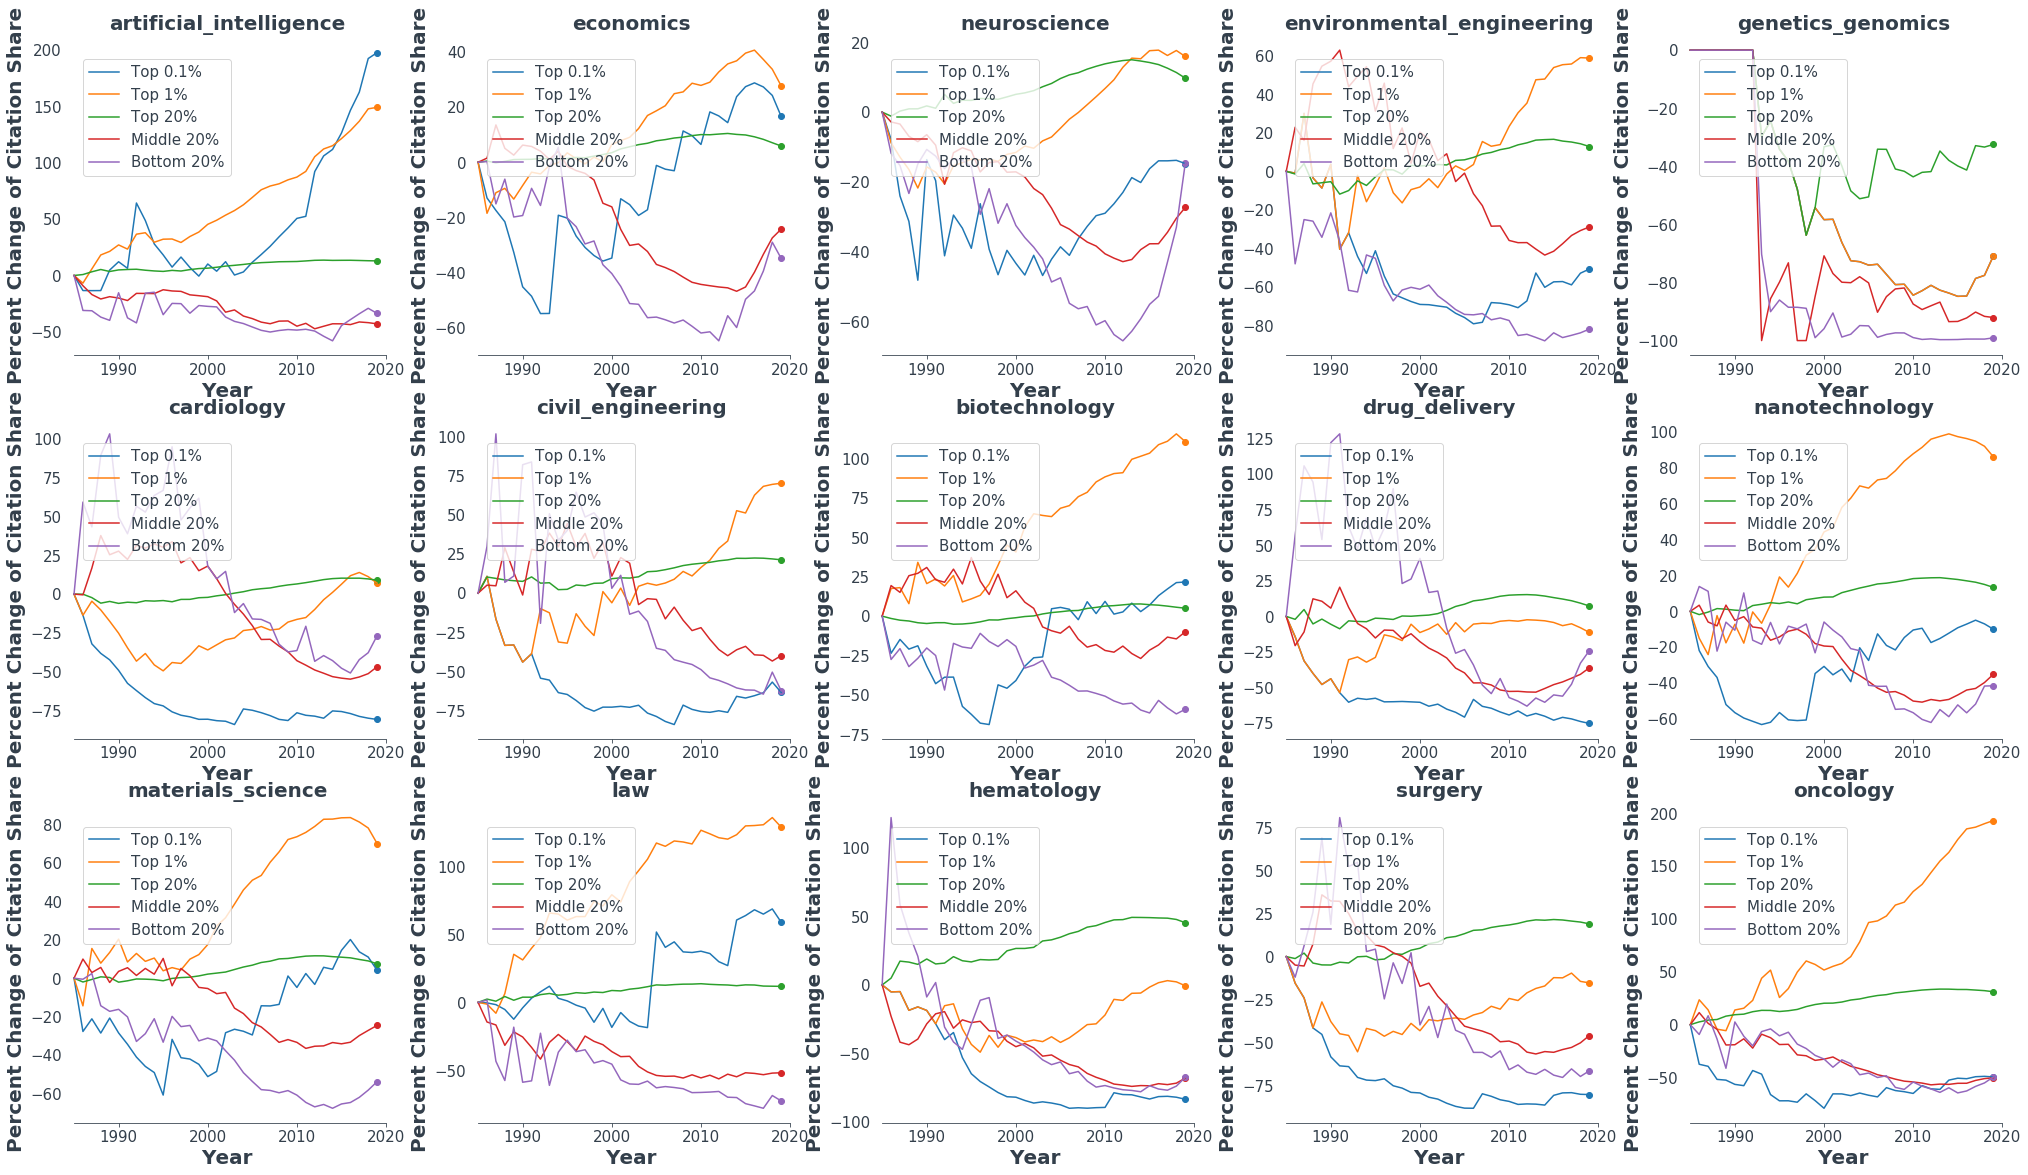

In [58]:
fig, all_ax = plt.subplots(nrows=3, ncols=5)

for name, ax in zip(results, all_ax.flatten()):
    plot(
        results[name], 
        title=name,
        metric_type='percent_per_year_percent_change',
        ax=ax
    )